In [42]:
# Importing the Required Libraries 

import pandas as pd 
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import random
import matplotlib.image as img
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
from skimage.io import imread
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torchvision import transforms as T, datasets 
from torch.utils.data import DataLoader 
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

# from helper import show_grid
%matplotlib inline

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ("The device we are on :{}".format(device))

The device we are on :cuda


In [44]:
import os
os.listdir('../input/facial-expression-dataset-image-folders-fer2013/data')
uni_path = '../input/facial-expression-dataset-image-folders-fer2013/data'

# os.listdir('C:/Users/shukl/OneDrive/Desktop/ML_project/Dataset')
# uni_path = 'C:/Users/shukl/OneDrive/Desktop/ML_project/Dataset'

In [45]:
# Getting the path to the dataset

train_path=uni_path+'/train'
val_path=uni_path+'/val'
test_path=uni_path+'/test'

print (type(train_path))

<class 'str'>


In [46]:
# Image Transformation and Augumentation 
train_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(
        mean = [0.485 , 0.456 , 0.406] ,
        std = [0.229 , 0.224 , 0.225])
])

valid_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(
        mean = [0.485 , 0.456 , 0.406] ,
        std = [0.229 , 0.224 , 0.225])
    ])

test_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(
        mean = [0.485 , 0.456 , 0.406] ,
        std = [0.229 , 0.224 , 0.225])
    ])

train_ds = datasets.ImageFolder(train_path, transform = train_transform)
valid_ds = datasets.ImageFolder(val_path, transform = valid_transform)
test_ds = datasets.ImageFolder(test_path, transform = test_transform)
print (len(train_ds))
print (len(valid_ds))
print (len(test_ds))

28709
3589
3589


In [47]:
# Definging the batch size 
batch_size = 64

# Loading the Dataset 
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size = batch_size)
test_dl = DataLoader(test_ds, batch_size = batch_size)
print (len(train_dl))
print (len(valid_dl))
print (len(test_dl))

449
57
57


In [48]:
# Building The CNN model

class AlexNet(Module):   
    def __init__(self, num_classes: int = 7, dropout: float = 0.5):
        super(AlexNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [49]:
model = AlexNet()
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [50]:
# Building Trainer using Train Loader and Validation Loader 

class Trainer():
    
    def __init__(self, criterion, optimizer, schedular):
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
        
    def train_batch_loop(self, model, trainloader):
        
        train_acc = 0.0
        train_loss = 0.0
        
        for images, labels in tqdm(trainloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits, labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss = train_loss + loss.item()
            
            softmax = torch.exp(logits).cpu()
            
            prob = list(softmax.detach().numpy())
            
            logits = np.argmax(prob, axis=1)
            labels = labels.detach().cpu().numpy()
            train_acc = train_acc + accuracy_score(logits, labels)
            
        return train_acc/ len(trainloader), train_loss/ len(trainloader)
    
    def valid_batch_loop(self, model, validloader):
        
        valid_acc = 0.0
        valid_loss = 0.0
        
        for images, labels in tqdm(validloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits, labels)
                        
            valid_loss = valid_loss + loss.item()
            softmax = torch.exp(logits).cpu()
            prob = list(softmax.detach().numpy())
            logits = np.argmax(prob, axis=1)
            labels = labels.detach().cpu().numpy()
            valid_acc = valid_acc + accuracy_score(logits, labels)
            _
        return valid_acc/ len(validloader), valid_loss/ len(validloader)
    
    def test_batch_loop(self, model, testloader):
        
        test_acc = 0.0
        test_loss = 0.0
        
        test_predictions = []
        test_labels = []
        
        for images, labels in tqdm(testloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits, labels)
                        
            test_loss = test_loss + loss.item()
            softmax = torch.exp(logits).cpu()
            prob = list(softmax.detach().numpy())
            logits = np.argmax(prob, axis=1)
            labels = labels.detach().cpu().numpy()
            test_acc = test_acc + accuracy_score(logits, labels)
            test_predictions.append(logits)
            test_labels.append(labels)
            _
        return test_predictions , test_labels ,test_acc/ len(testloader), test_loss/ len(testloader)
    
    def fit(self,model, trainloader, validloader, epochs):
        
       
        model = model.to(device)
        valid_min_loss = np.Inf
        
        training_loss = []
        validation_loss = []
        training_acc = []
        validation_acc = []
        
        
        for i in range(epochs):            
            
            # Training of Model
            model.train()
            avg_train_acc, avg_train_loss = self.train_batch_loop(model, trainloader)
            
            # Storing train loss and train accuracy
            training_loss.append(avg_train_loss)
            training_acc.append(avg_train_acc)
            
            
            # Validation of model
            model.eval()
            avg_valid_acc, avg_valid_loss = self.valid_batch_loop(model, validloader)
            
            # Storing Validation loss
            validation_loss.append(avg_valid_loss)
            validation_acc.append(avg_valid_acc)
            
            
            # Getting Train and Validation Accuracies
            train_acc = avg_train_acc
            val_acc = avg_valid_acc
            
            print ("Epoch:{}".format(i), "Train Loss:{}".format(avg_train_loss), "Validation Loss:{}".format(avg_valid_loss))
            
        return training_acc, validation_acc, training_loss, validation_loss
                    
            
            
            

In [51]:
# Training The Model 

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
schedular = None 

trainer = Trainer(criterion, optimizer, schedular)
trn_acc, val_acc, training_ls , validation_ls = trainer.fit(model, train_dl, valid_dl, epochs = 50)


100%|██████████| 57/57 [00:09<00:00,  5.77it/s]


Epoch:0 Train Loss:1.7536330114228689 Validation Loss:1.6652553206995915


100%|██████████| 57/57 [00:11<00:00,  4.79it/s]


Epoch:1 Train Loss:1.599804378830245 Validation Loss:1.4798684643025983


100%|██████████| 57/57 [00:11<00:00,  5.04it/s]


Epoch:2 Train Loss:1.4997224414799952 Validation Loss:1.4159320122317265


100%|██████████| 57/57 [00:11<00:00,  4.96it/s]


Epoch:3 Train Loss:1.4450344739353205 Validation Loss:1.3930894648819638


100%|██████████| 57/57 [00:11<00:00,  4.97it/s]


Epoch:4 Train Loss:1.3978777736226276 Validation Loss:1.344955561453836


100%|██████████| 57/57 [00:11<00:00,  5.02it/s]


Epoch:5 Train Loss:1.3545369308085113 Validation Loss:1.3094880591359055


100%|██████████| 57/57 [00:11<00:00,  4.77it/s]


Epoch:6 Train Loss:1.3209151611030765 Validation Loss:1.293279504566862


100%|██████████| 57/57 [00:11<00:00,  4.94it/s]


Epoch:7 Train Loss:1.283624213230371 Validation Loss:1.2622580465517546


100%|██████████| 57/57 [00:11<00:00,  4.88it/s]


Epoch:8 Train Loss:1.2556558542102907 Validation Loss:1.2761222563291852


100%|██████████| 57/57 [00:11<00:00,  5.05it/s]


Epoch:9 Train Loss:1.2386298960195088 Validation Loss:1.2703661092540675


100%|██████████| 57/57 [00:09<00:00,  5.77it/s]


Epoch:10 Train Loss:1.2033750616627972 Validation Loss:1.2727197398219192


100%|██████████| 57/57 [00:11<00:00,  4.82it/s]


Epoch:11 Train Loss:1.1736534079889411 Validation Loss:1.2724763081784833


100%|██████████| 57/57 [00:11<00:00,  5.01it/s]


Epoch:12 Train Loss:1.1424649773302482 Validation Loss:1.245455891416784


100%|██████████| 57/57 [00:11<00:00,  4.78it/s]


Epoch:13 Train Loss:1.1154847644219685 Validation Loss:1.2439962960126107


100%|██████████| 57/57 [00:11<00:00,  4.96it/s]


Epoch:14 Train Loss:1.0759806263951257 Validation Loss:1.2526822968533164


100%|██████████| 57/57 [00:11<00:00,  4.84it/s]


Epoch:15 Train Loss:1.0509161857560376 Validation Loss:1.2344717059219092


100%|██████████| 57/57 [00:11<00:00,  4.85it/s]


Epoch:16 Train Loss:1.0251979567691318 Validation Loss:1.2120323777198792


100%|██████████| 57/57 [00:12<00:00,  4.70it/s]


Epoch:17 Train Loss:0.9994443564744198 Validation Loss:1.2213650230775799


100%|██████████| 57/57 [00:11<00:00,  5.06it/s]


Epoch:18 Train Loss:0.9561634203107957 Validation Loss:1.230392159600007


100%|██████████| 57/57 [00:11<00:00,  5.12it/s]


Epoch:19 Train Loss:0.9248473843381241 Validation Loss:1.2288686162547062


100%|██████████| 57/57 [00:09<00:00,  5.83it/s]


Epoch:20 Train Loss:0.8971633400046215 Validation Loss:1.2225874610114515


100%|██████████| 57/57 [00:10<00:00,  5.43it/s]


Epoch:21 Train Loss:0.861221561851374 Validation Loss:1.2236261383483285


100%|██████████| 57/57 [00:11<00:00,  4.97it/s]


Epoch:22 Train Loss:0.8321969177250341 Validation Loss:1.220923940340678


100%|██████████| 57/57 [00:11<00:00,  4.80it/s]


Epoch:23 Train Loss:0.8047908534584173 Validation Loss:1.2510042661114742


100%|██████████| 57/57 [00:11<00:00,  4.99it/s]


Epoch:24 Train Loss:0.7713544517423634 Validation Loss:1.2465218964375948


100%|██████████| 57/57 [00:11<00:00,  4.81it/s]


Epoch:25 Train Loss:0.7480583829444342 Validation Loss:1.261909126189717


100%|██████████| 57/57 [00:11<00:00,  4.98it/s]


Epoch:26 Train Loss:0.7351067386783311 Validation Loss:1.2448834677537282


100%|██████████| 57/57 [00:11<00:00,  4.97it/s]


Epoch:27 Train Loss:0.6916315232326831 Validation Loss:1.2633063573586314


100%|██████████| 57/57 [00:11<00:00,  4.95it/s]


Epoch:28 Train Loss:0.676873309707854 Validation Loss:1.2778094729833436


100%|██████████| 57/57 [00:11<00:00,  5.00it/s]


Epoch:29 Train Loss:0.6495344276417603 Validation Loss:1.3523933343720018


100%|██████████| 57/57 [00:11<00:00,  4.80it/s]


Epoch:30 Train Loss:0.6301798484638699 Validation Loss:1.2668979256822352


100%|██████████| 57/57 [00:09<00:00,  5.80it/s]


Epoch:31 Train Loss:0.6177294357847796 Validation Loss:1.2830228303608142


100%|██████████| 57/57 [00:09<00:00,  5.91it/s]


Epoch:32 Train Loss:0.5964314393981263 Validation Loss:1.336048577438321


100%|██████████| 57/57 [00:11<00:00,  4.86it/s]


Epoch:33 Train Loss:0.5654142475075074 Validation Loss:1.267164952399438


100%|██████████| 57/57 [00:11<00:00,  4.98it/s]


Epoch:34 Train Loss:0.5594004215402965 Validation Loss:1.3144623726083522


100%|██████████| 57/57 [00:11<00:00,  4.80it/s]


Epoch:35 Train Loss:0.5366044841325097 Validation Loss:1.3629350291009534


100%|██████████| 57/57 [00:11<00:00,  4.99it/s]


Epoch:36 Train Loss:0.5101795572878789 Validation Loss:1.3220479864823191


100%|██████████| 57/57 [00:11<00:00,  4.79it/s]


Epoch:37 Train Loss:0.5063843309945678 Validation Loss:1.334390655421374


100%|██████████| 57/57 [00:11<00:00,  5.03it/s]


Epoch:38 Train Loss:0.4957755963029734 Validation Loss:1.351747793063783


100%|██████████| 57/57 [00:11<00:00,  5.05it/s]


Epoch:39 Train Loss:0.4601989887936875 Validation Loss:1.3809647466007031


100%|██████████| 57/57 [00:11<00:00,  4.89it/s]


Epoch:40 Train Loss:0.4498219043680183 Validation Loss:1.4278207975521422


100%|██████████| 57/57 [00:11<00:00,  5.00it/s]


Epoch:41 Train Loss:0.45444972331911526 Validation Loss:1.334221516262021


100%|██████████| 57/57 [00:10<00:00,  5.69it/s]


Epoch:42 Train Loss:0.4390272499458296 Validation Loss:1.4063323537508647


100%|██████████| 57/57 [00:09<00:00,  5.70it/s]


Epoch:43 Train Loss:0.4228737067207196 Validation Loss:1.40174915288624


100%|██████████| 57/57 [00:11<00:00,  5.04it/s]


Epoch:44 Train Loss:0.43524284735487934 Validation Loss:1.3469469683212147


100%|██████████| 57/57 [00:11<00:00,  5.04it/s]


Epoch:45 Train Loss:0.3988451945091409 Validation Loss:1.3977421464627249


100%|██████████| 57/57 [00:11<00:00,  4.97it/s]


Epoch:46 Train Loss:0.3874980107381243 Validation Loss:1.431350531808117


100%|██████████| 57/57 [00:11<00:00,  4.82it/s]


Epoch:47 Train Loss:0.37333963773231993 Validation Loss:1.470104341967064


100%|██████████| 57/57 [00:11<00:00,  5.01it/s]


Epoch:48 Train Loss:0.39134651651493957 Validation Loss:1.405233459514484


100%|██████████| 57/57 [00:11<00:00,  4.88it/s]

Epoch:49 Train Loss:0.3470492683566758 Validation Loss:1.3873818265764337


In [52]:
print ("The list of the Training loss:", training_ls)
print ("The List of the Validation Loss:", validation_ls)

The list of the Training loss: [1.7536330114228689, 1.599804378830245, 1.4997224414799952, 1.4450344739353205, 1.3978777736226276, 1.3545369308085113, 1.3209151611030765, 1.283624213230371, 1.2556558542102907, 1.2386298960195088, 1.2033750616627972, 1.1736534079889411, 1.1424649773302482, 1.1154847644219685, 1.0759806263951257, 1.0509161857560376, 1.0251979567691318, 0.9994443564744198, 0.9561634203107957, 0.9248473843381241, 0.8971633400046215, 0.861221561851374, 0.8321969177250341, 0.8047908534584173, 0.7713544517423634, 0.7480583829444342, 0.7351067386783311, 0.6916315232326831, 0.676873309707854, 0.6495344276417603, 0.6301798484638699, 0.6177294357847796, 0.5964314393981263, 0.5654142475075074, 0.5594004215402965, 0.5366044841325097, 0.5101795572878789, 0.5063843309945678, 0.4957755963029734, 0.4601989887936875, 0.4498219043680183, 0.45444972331911526, 0.4390272499458296, 0.4228737067207196, 0.43524284735487934, 0.3988451945091409, 0.3874980107381243, 0.37333963773231993, 0.3913465

In [53]:
print ("Train Accuracy:{}".format(trn_acc), "Validation Accuracy:{}".format(val_acc))

Train Accuracy:[0.2816873457533257, 0.3714165864082345, 0.4190797492927225, 0.44199666676698973, 0.4551038719677361, 0.47610681394088966, 0.49351599650875816, 0.5083819900078252, 0.5148453018720279, 0.5286033527960031, 0.5366740278697406, 0.5526028185758142, 0.5657222506470836, 0.5720303753084933, 0.5899361569252995, 0.5989972085114067, 0.6114140657918498, 0.6196521549389032, 0.6384881192439655, 0.6501337431529525, 0.6606432086317944, 0.6756606272196473, 0.6916938165894179, 0.6987609477517607, 0.7127315581171372, 0.7201128257990731, 0.7291447210016253, 0.7439411153915608, 0.7521349996990309, 0.7586923644134111, 0.7693636007945586, 0.7734567808342864, 0.7831000195629929, 0.7955234605429483, 0.7996138189971709, 0.8078519081442245, 0.8166533738638415, 0.8164793760910131, 0.8227461174983447, 0.8351855474628304, 0.8401176789261421, 0.839946502738819, 0.8455304204538615, 0.8521047146812737, 0.8487827680130018, 0.8614056010353337, 0.8657555453560464, 0.8696088906278215, 0.8652617678926142, 0.

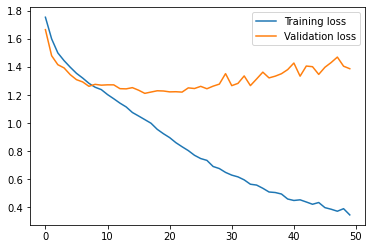

In [54]:
# Plotting Train Loss and Validation Loss
plt.plot(training_ls, label ='Training loss')
plt.plot(validation_ls, label ='Validation loss')


plt.legend()
plt.show()

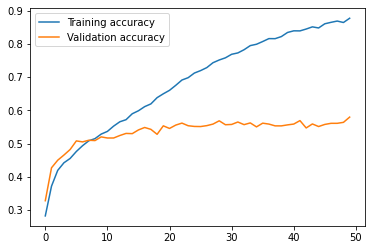

In [55]:
# Plotting Train accuracy and Validation accuracy 
plt.plot(trn_acc, label = "Training accuracy")
plt.plot(val_acc, label = "Validation accuracy")


plt.legend()
plt.show()

In [56]:
# Checking on Test Data

model.eval()
predictions , labels ,avg_test_acc, avg_test_loss = trainer.test_batch_loop(model, test_dl)

100%|██████████| 57/57 [00:11<00:00,  5.01it/s]


In [57]:
print (avg_test_acc)
print (avg_test_loss)

0.5571271929824562
1.460396268911529


In [58]:
predictions = np.concatenate(predictions, axis = 0)
labels = np.concatenate(labels,axis = 0)

print(len(labels))
print(len(predictions))

print(accuracy_score(labels, predictions))


3589
3589
0.5564224017832266


Each class accuracies
[0.40733198 0.47272727 0.41666667 0.80432309 0.42929293 0.66346154
 0.5       ]


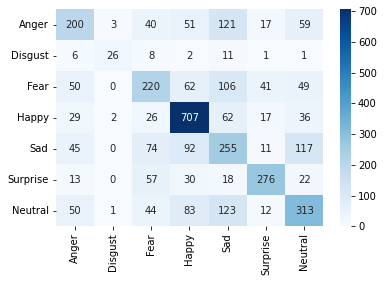

In [59]:
class_names = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise','Neutral']
cm = confusion_matrix(labels , predictions)
df_cm = pd.DataFrame(cm,class_names,class_names)
ax= plt.subplot()
sns.heatmap(df_cm, annot=True, fmt='g', ax=ax , cmap = "Blues");

print("Each class accuracies")
print((cm.diagonal()/cm.sum(axis=1)))

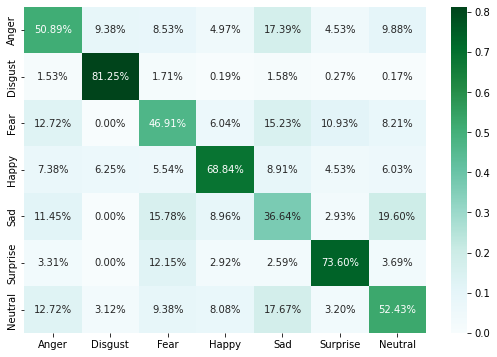

In [66]:
plt.figure(figsize = (9,6))
ax1 = plt.subplot()
sns.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.2%', ax=ax1 , cmap = "BuGn");


In [61]:
multilabel_confusion_matrix(labels , predictions)

array([[[2905,  193],
        [ 291,  200]],

       [[3528,    6],
        [  29,   26]],

       [[2812,  249],
        [ 308,  220]],

       [[2390,  320],
        [ 172,  707]],

       [[2554,  441],
        [ 339,  255]],

       [[3074,   99],
        [ 140,  276]],

       [[2679,  284],
        [ 313,  313]]])

In [62]:
print(classification_report(labels,predictions))

              precision    recall  f1-score   support

           0       0.51      0.41      0.45       491
           1       0.81      0.47      0.60        55
           2       0.47      0.42      0.44       528
           3       0.69      0.80      0.74       879
           4       0.37      0.43      0.40       594
           5       0.74      0.66      0.70       416
           6       0.52      0.50      0.51       626

    accuracy                           0.56      3589
   macro avg       0.59      0.53      0.55      3589
weighted avg       0.56      0.56      0.55      3589

